In this two-part blog post, I will discuss unsupervised learning. In the first part, I will discuss SVD and its application for image compression. And in the second part, I will discuss Spectral Clustering and K-Means Clustering for use in graph partitioning.

In [154]:
#| echo: false
#| output: false

%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import PIL
import urllib
import networkx as nx
from ImageCompressionSVD import ImageCompressionSVD
from SpectralCommunityDetection import SpectralCommunityDetection
import warnings
warnings.filterwarnings("ignore")


In [155]:
#| echo: false
#| output: false

def read_image(url):
    return np.array(PIL.Image.open(urllib.request.urlopen(url)))

## SVD for Image Compression

Singular-Value Decomposition (SVD) is a matrix factorization technique that can be used to reduce the dimensionality of a matrix. In part 1, I will show how we can exploit dimensionality reduction to compress images.

We will start by choosing a benchmark image to work with. I will use the following image of a cheetah since it includes lots of fine detail and high contrast. 

Observe below the detail in

1. the cheetah's fur
2. the grass blades
3. the blurred background
4. and in the gradient of the cheetah's spots as it approaches the face

For ease of use, I will convert the image to grayscale and then to a numpy array.


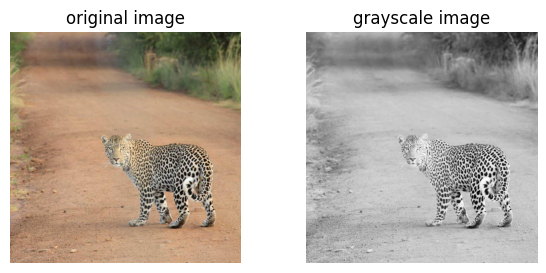

In [156]:
#| code-fold: false 

image_url = "https://fastly.picsum.photos/id/219/1200/1200.jpg?hmac=hVx7D_aNUjlmtlaYidaqbaIOhwFFYwkL1VrMXiFFFCY"
img = read_image(image_url)

img_grey = ImageCompressionSVD.to_grayscale_image(img)
ImageCompressionSVD.compare_images(img, img_grey, "original image", "grayscale image")


Our solution compresses images by takeing a subset of size $k$ of the singular values. The following code shows how we can do this using the `numpy.linalg.svd` function.


```python
    def compress_image(img, k):
        u, s, v = np.linalg.svd(img)
        return u[:, :k] @ np.diag(s[:k]) @ v[:k, :]
```

Specifically, we take:

1. The first k columns of U.
2. The top k singular values in S
3. The first k rows of V.



We also consider an extension to this compression by letting our user specify a value of $\epsilon$ that filters out singular values that are less than $\epsilon$. 


```python
    def compress_image(img, k, epsilon = None):
        u, s, v = np.linalg.svd(img)
        if epsilon is not None:
            s[s < epsilon] = 0
        return u[:, :k] @ np.diag(s[:k]) @ v[:k, :]

```


We can now compare the original image to the compressed image. We will use the `ImageCompressionSVD.compare_images` method to do this.

```python
    def compare_images(A, A_, title_1 = "original image", title_2 = "reconstructed image"):
        fig, axarr = plt.subplots(1, 2, figsize = (7, 3))

        axarr[0].imshow(A, cmap = "Greys")
        axarr[0].axis("off")
        axarr[0].set(title = title_1)

        axarr[1].imshow(A_, cmap = "Greys")
        axarr[1].axis("off")
        axarr[1].set(title = title_2)

```


The `ImageCompressionSVD.svd_reconstruct` method will do the entire compression and comparison pipeline for us.

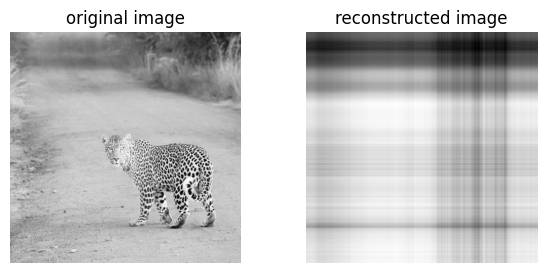

In [157]:
#| code-fold: false
ImageCompressionSVD.svd_reconstruct(img, 1)

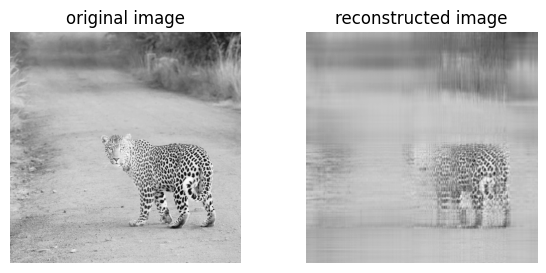

In [158]:
#| code-fold: false
ImageCompressionSVD.svd_reconstruct(img, 15)

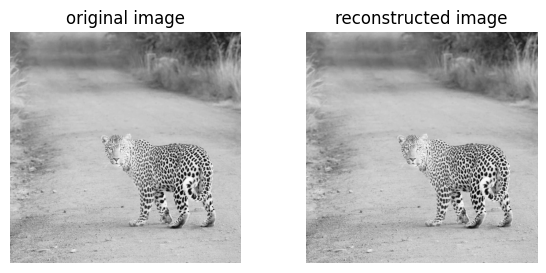

In [159]:
#| code-fold: false
ImageCompressionSVD.svd_reconstruct(img, 1000)

Compression with $k=1$ is unrecognizable.

So compressing with $k=15$ doesn't give us a great image but the image is still recognizable.

And compressing with $k=1000$ gives us a pretty good image.

But what exactly is our cost savings here? And how do we choose $k$?

We can compute the relative size of our images mathematically. The following code computes the relative size of the compressed image to the original image.

```python
    def get_relative_size(A, k):
        A_space = A.shape[0] * A.shape[1]
        A_compressed_space = k * (A.shape[0] + A.shape[1]) + k
        return A_compressed_space / A_space

```

In our compressed image we keep the first $k$ rows of $U$ (which has shape $m \times m$), the first $k$ columns of $V$ (which has shape $n \times n$), and the first $k$ singular values in $S$ (which has shape $m \times n$).

This gives us $k \cdot m$ elements from $U$, $k \cdot n$ elements from $V$, and $k$ elements from $S$. So our total number of elements is $k \cdot (m + n) + k$.



But how useful is this compression if the images it produces are low-quality?

To experiment with our solution, we will run our SVD compression -> decompression pipeline on the image with different values of $k$. We will then compare the original image to the decompressed image for each value of $k$. And we wll observe the relative size of the compressed image to the original image for each value of $k$.

relative size for k = 10: 0.01667361111111111


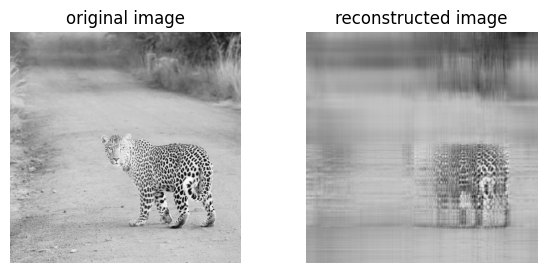

relative size for k = 50: 0.08336805555555556


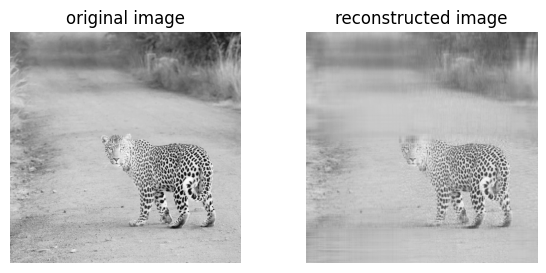

relative size for k = 100: 0.1667361111111111


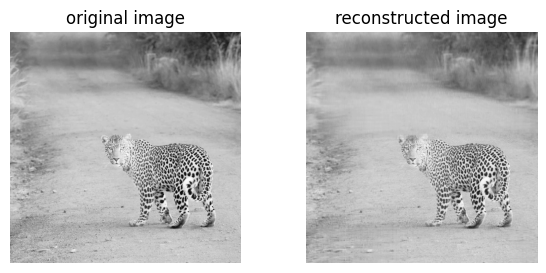

relative size for k = 200: 0.3334722222222222


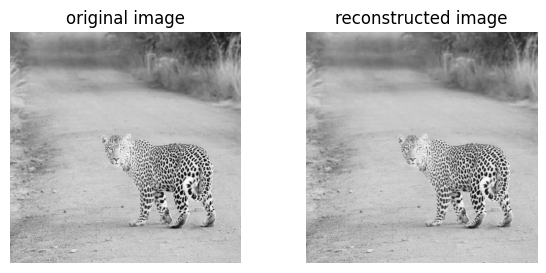

In [160]:
#| code-fold: false

k_values = [10, 50, 100, 200]
ImageCompressionSVD.svd_experiment(img, k_values)

So we can see the images are about identical at $k=200$ and the relative size is about $\frac{1}{3}$ of the original image! This means we can compress our image by a factor of 3 and still have a very high quality image.

Now what if we need to compress our image by a certain amount? We could test a bunch of $k$ values ourselves but that would be tedious. Instead, we can use the `ImageCompressionSVD.find_k_for_compression_threshold` method to do this for us. Since this our relative-size method uses only simple math, it is very fast. If we were even more concerned about speed, we could switch to using binary search instead of linear search.

So, if I need to make an image 3x smaller, I can call `find_k_for_compression_threshold` with a compression_factor of 3 and it will return the value of $k$ that will give me a compressed image that is 1/3 the size of the original image.

In [161]:
#| code-fold: false

# I want to make the image 3x smaller
compression_factor = 3
k = ImageCompressionSVD.find_k_for_compression_threshold(img, compression_factor)
print(f"{k = }",)


threshold: 0.3333333333333333
k = 199


Here we can see that value of $k$ is 199. So as evidenced above, we can compress our image by a factor of 3 and still have a very high quality image.

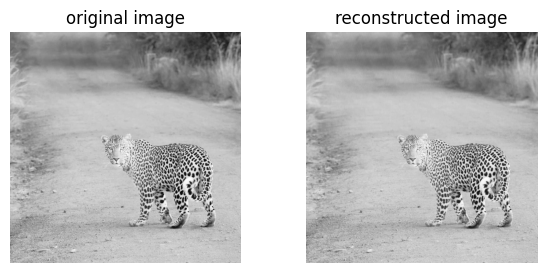

In [162]:
ImageCompressionSVD.svd_reconstruct(img, k)


Now we can also use our $\epsilon$ parameter to filter out singular values that are less than $\epsilon$. This could be used to additionally improve our compression (if we are using sparse matrix formats).

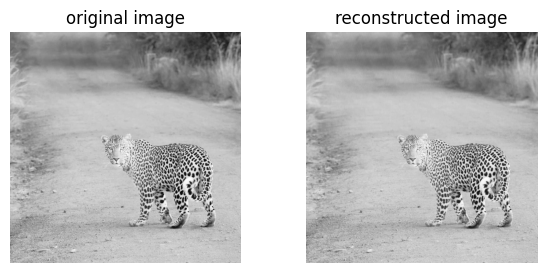

In [163]:
#| code-fold: false

# I want to ignore all singular values less than epsilon

epsilon = 1e-4
ImageCompressionSVD.svd_reconstruct(img, k, epsilon)


But we do need to be careful, consider what happens if we use an epsilon value that is too large. Observe the following image.

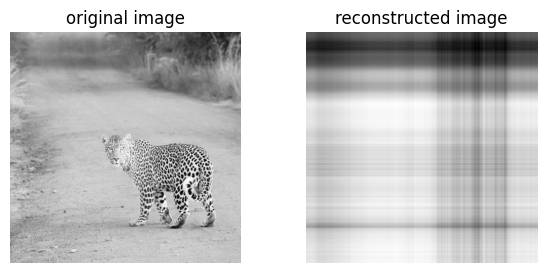

In [164]:
#| code-fold: false

# What happens if epsilon is too large?

epsilon = 20000

ImageCompressionSVD.svd_reconstruct(img, k, epsilon)


Recall this similar to the initial compression examples with $k=1$

## Spectral Clustering

In part 2, I will discuss Spectral Clustering for use in graph partitioning. We will start with the famous Karate Club graph.

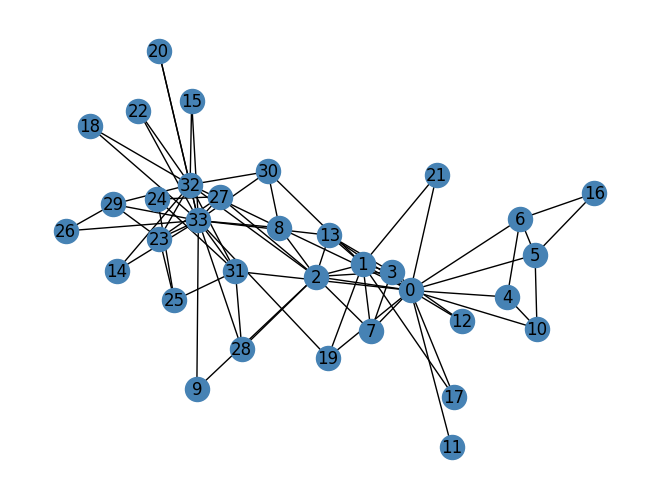

In [165]:
G = nx.karate_club_graph()
layout = nx.layout.fruchterman_reingold_layout(G)
nx.draw(G, layout, with_labels=True, node_color = "steelblue")

We will use the `club` label to denote the true partition of the graph. As shown in the figure below, the graph has 2 communities and split it into 2 roughly equal parts.

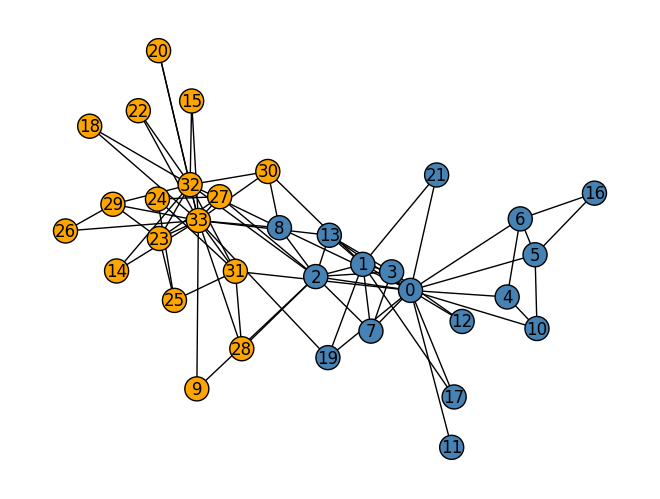

In [166]:
clubs = nx.get_node_attributes(G, "club")
nx.draw(G, layout,
        with_labels=True, 
        node_color = ["orange" if clubs[i] == "Officer" else "steelblue" for i in G.nodes()],
        edgecolors = "black" # confusingly, this is the color of node borders, not of edges
        ) 

We will use the `SpectralCommunityDetection` class to do the clustering. The `SpectralCommunityDetection.spectral_clustering` method will do the entire clustering pipeline for us.

```python
    def get_clusters(cls, G, k):
        L = cls.get_laplacian_matrix(G)
        X = cls.get_eigenvectors(L, k)
        return cls.k_means_clustering(X, k)
    
    def spectral_clustering(cls, G, k=2):
        clusters = cls.get_clusters(G, k)
        return cls.build_community_label_vector(clusters, k)

```

To do the clustering, we will use the following steps:

1. Get the Laplacian matrix of the graph.
2. Get k eigenvectors sorted by eigenvalue from the Laplacian matrix.
3. Cluster the eigenvectors using k-means into k clusters.
4. Output a vector of labels in the same order as the nodes in the graph.

We will use the `SpectralCommunityDetection.get_laplacian_matrix` method to get the Laplacian matrix of the graph.

```python
    def get_laplacian_matrix(cls, G):
        A = cls.get_adjacency_matrix(G)
        return np.diag(A.sum(axis=0)) - A

```

The Laplacian matrix is defined as $L = D - A$ where $D$ is the diagonal degree matrix and $A$ is the adjacency matrix.

Then we can get the eigenvectors of the Laplacian matrix using the `SpectralCommunityDetection.get_eigenvectors` method.

```python
    def get_eigenvectors(L, k):
        e_values, e_vectors = np.linalg.eig(L) 

        e_values = np.real(e_values) # We need to discard imaginary parts for kmeans
        e_vectors = np.real(e_vectors)

        idx = np.argsort(e_values)[:k]
        return e_vectors[:, idx]
```


And we can cluster the eigenvectors using k-means using the `SpectralCommunityDetection.k_means_clustering` method. We will use the `sklearn` implementation of k-means.

```python
    def k_means_clustering(X, k):
        kmeans = KMeans(n_clusters=k).fit(X)
        return kmeans.labels_
```

And finally we can build a vector of labels in the same order as the nodes in the graph using the `SpectralCommunityDetection.build_community_label_vector` method.

```python
    def build_community_label_vector(clusters, k):
        # [[0, 1, 2], [3, 4, 5]] -> [0, 0, 0, 1, 1, 1]
        community_labels = np.zeros(len(clusters)).astype(int)
        for i in range(k):
            community_labels[clusters == i] = i
        return community_labels

```


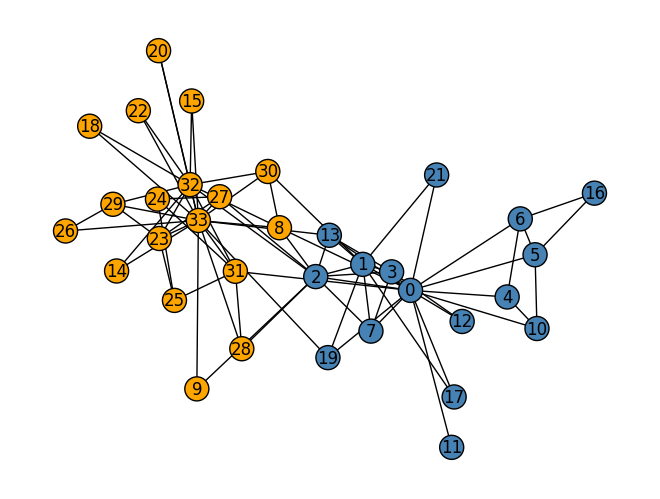

In [167]:
#| code-fold: false

communities = SpectralCommunityDetection.spectral_clustering(G, 2).tolist()
nx.draw(G, layout,
        with_labels=True,
        node_color = ["orange" if communities[i] == 1 else "steelblue" for i in G.nodes()],
        edgecolors = "black" # confusingly, this is the color of node borders, not of edges
)

None # suppress output


We make the classic mistake of mislabeling individual 8. But overwise, our labeling is very good. We can see that the clustering algorithm has correctly identified the 2 communities in the graph.

Now let's see how we can extend spectral clustering to scatterplots of points. Since we defined spectral clustrering over a graph, we can transform our points into a graph using the  `get_nearest_neighbor_graph` method. This method uses KNN to find the nearest neighbors (in Euclidean distance) on the scatterplot and sets them as neighbors in the graph. We can then use the same spectral clustering algorithm to cluster the points.

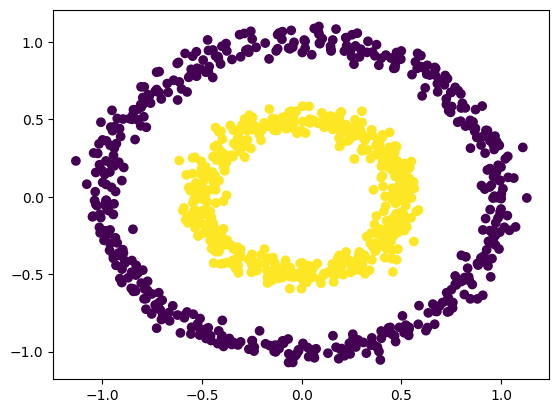

In [168]:
#| echo: false

from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, noise=0.05, factor=0.5)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

None # suppress output

But now we need to be careful as our constructed graph relies on a hyperparameter, K. As shown below, a wrong choice of K can lead to an obvious misclassification of points.

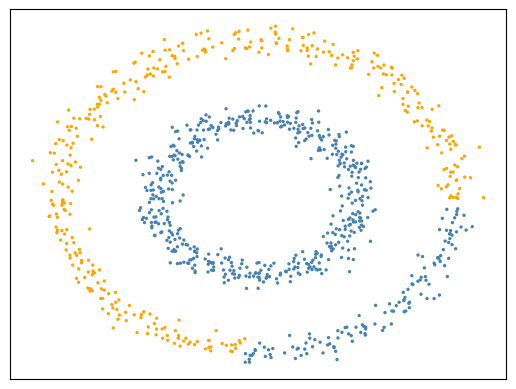

In [169]:
np.random.seed(0)
GC = SpectralCommunityDetection.get_nearest_neighbor_graph(X, 6)
communities = SpectralCommunityDetection.spectral_clustering(GC, 2).tolist()

colors = ["orange", "steelblue"]

nx.draw_networkx_nodes(
    GC,
    pos = {i: X[i] for i in range(len(X))},
    node_color = [colors[i] for i in communities],
    node_size = 2
)

None

Now let's show that we can use this algorithm with a better choice of K and that we can use it to cluster multiple classes of points. We will do this by adding two more circles to our scatterplot from `sklearn.datasets.make_circles`.

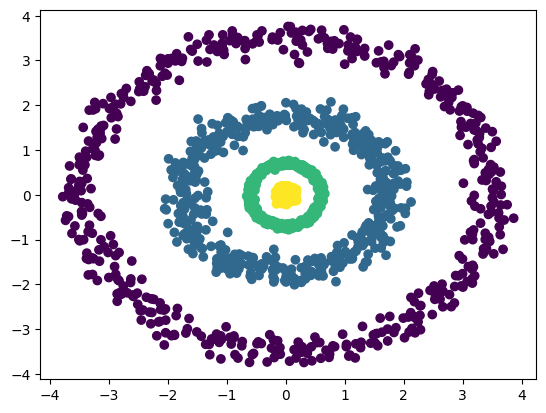

In [170]:
# 4 rings

X_large, y_large = make_circles(n_samples=1000, noise=0.05, factor=0.5)
X_small, y_small = make_circles(n_samples=1000, noise=0.05, factor=0.2)

X_large[:, 0] *= 3.5
X_large[:, 1] *= 3.5
X_small[:, 0] *= 0.6
X_small[:, 1] *= 0.7
y_small += 2

X = np.concatenate([X_large, X_small])
y = np.concatenate([y_large, y_small])

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()
None

Observe the 4 distinct classifications of points. We want our algorithm to return a classification of points that looks like this.

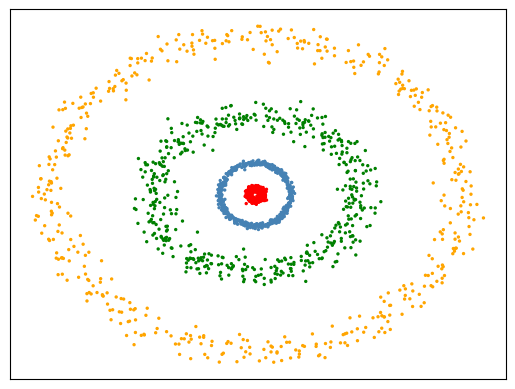

In [171]:
#| code-fold: false

np.random.seed(0)
GMC = SpectralCommunityDetection.get_nearest_neighbor_graph(X, 12)
communities = SpectralCommunityDetection.spectral_clustering(GMC, 4).tolist()


colors = ["orange", "steelblue", "green", "red"]

nx.draw_networkx_nodes(
    GMC,
    pos = {i: X[i] for i in range(len(X))},
    node_color = [colors[i] for i in communities],
    node_size = 2
)


While this looks good to my eyes, how can we quantitatively determine if this labeling is good? 

Unfortunately, the classes returned by our algorithm do not have the same numerical identifiers as the classes in the original dataset. So we need to find a way to evaluate the quality of our clustering. We will do this by using a similarity measure.

For a measure of similarity $[0, 1]$ between two categorical labelings $z_1$ and $z_2$ that is permutation invariant, I propose we consider the averaged Jaccard Index about each point $i$: such that $sim(z_1, z_2) = \frac{1}{n}\sum_{i=1}^n 
J(label(z_1, i), label(z_2, i))$

where $label(z_i, j)$ = returns the label group $g_{i,j}$ of point $j$ in $z_i$. and where $J(g_{i,j}, g_{n, j})$ is the Jaccard Index between the group that contains point $j$ in $z_i$ and the group that contains point $j$ in $z_n$.



In [172]:
#| code-fold: false

def jaccard_index(gi: list, gj: list):
    """compute the jaccard index between two node label groups"""
    return len(set(gi).intersection(set(gj))) / len(set(gi).union(set(gj)))


def averaged_jaccard_index_sim(labels:list, zi: list, zj: list):
    """compute the average jaccard index between node label groups in zi and zj"""

    zi_node_to_group_map = {node: group for node, group in enumerate(zi)} # exactly zi
    zj_node_to_group_map = {node: group for node, group in enumerate(zj)}

    zi_group_to_node_map = {group: [] for group in set(labels)}
    zj_group_to_node_map = {group: [] for group in set(labels)}

    for node, group in enumerate(zi):
        zi_group_to_node_map[group].append(node)
    
    for node, group in enumerate(zj):
        zj_group_to_node_map[group].append(node)

    jaccard_index_sum = 0
    for node, _ in enumerate(zi):
        zi_group = zi_node_to_group_map[node]
        zj_group = zj_node_to_group_map[node]
        zi_node_list = zi_group_to_node_map[zi_group]
        zj_node_list = zj_group_to_node_map[zj_group]

        jaccard_index_sum += jaccard_index(zi_node_list, zj_node_list)

    return jaccard_index_sum / len(zi)





As an example of this measure, let's consider the Karate Club example from earlier.

In [173]:
#| code-fold: false

actual_labeling = [0 if clubs[i] == "Officer" else 1 for i in G.nodes()]
predicted_labeling = SpectralCommunityDetection.spectral_clustering(G, 2)
labels = [0, 1]

sim = averaged_jaccard_index_sim(labels, actual_labeling, predicted_labeling)


# Test label invariance
actual_labeling = [1 if clubs[i] == "Officer" else 0 for i in G.nodes()]
predicted_labeling = SpectralCommunityDetection.spectral_clustering(G, 2)
labels = [0, 1]

sim2 = averaged_jaccard_index_sim(labels, actual_labeling, predicted_labeling)

print(f"{sim = :.3f}")
if np.isclose(sim, sim2):
    print("Label invariance works!")

sim = 0.916
Label invariance works!


So our similarity measure is label invariant and is defined on $[0,1]$.  A high similarly score means that two labeling are similar. So this measure confirms that our spectral clustering is good at classifying the communities in the Karate Club graph.

Now let's use this measure to see how well we did on the rings of circles example.

In [174]:
#| code-fold: false

actual_labeling = y
predicted_labeling = SpectralCommunityDetection.spectral_clustering(GMC, 4)
labels = [0, 1, 2, 3]

sim = averaged_jaccard_index_sim(labels, actual_labeling, predicted_labeling)
print(f"{sim = :.3f}")


sim = 1.000


Our spectral clustering is very good at classifying the communities in our rings of circles graph (with the added caveat that we needed to fiddle with the K value during the KNN graph construction step)